#### Vectorization and Parallelization
1. Vectorization and parallelization are done with two transformations, namely **`vmap`** and **`pmap`**
2. To illustrate these functions we start with a typical dot product example using **`numpy`**

In [174]:
import numpy as np

# What if we want to do dot products for a batch of vectors?
array1 = np.stack([np.array([1, 2, 3, 4]) for i in range(5)])
array2 = np.stack([np.array([5, 6, 7, 8]) for i in range(5)])

# We can use `einsum`
print(np.einsum('ij,ij-> i', array1, array2))

[70 70 70 70 70]


##### What is vmap
1. In the above, we used functions that operate on batches of data such as **`einsum`** to get the dot products of the rows of both matrices
2. The same can be done with another transformation, **`vmap`**. **`vmap`** takes a function as an input along the dimensions for hte inputs and the outputs where the functions is to be mapped over to create a vectorized function. The syntax looks like this **`vmap(function, in_axes, out_axes, ...)`**

In [175]:
import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import grad, vmap, pmap, jit

# A batch of vectors
array1 = np.stack([np.array([1, 2, 3, 4]) for i in range(5)])
array2 = jnp.stack([jnp.array([5, 6, 7, 8]) for i in range(5)])

# Singular operation to be performed by vmap
def dot_product(array1, array2):
    """Performs dot product on two jax arrays."""
    return jnp.dot(array1, array2)

# Vmapped function
func = vmap(dot_product, in_axes=(0,0), out_axes=(0))

# Further transformation with jit
jitted_func = jit(func)

%time res1 = func(array1, array2)
%time res2 = jitted_func(array1, array2)
%time res3 = jitted_func(array1, array2)

print(res1)
print(res3)


CPU times: user 589 µs, sys: 79 µs, total: 668 µs
Wall time: 597 µs
CPU times: user 14.6 ms, sys: 4.41 ms, total: 19 ms
Wall time: 17.2 ms
CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 65.8 µs
[70 70 70 70 70]
[70 70 70 70 70]


3. Now, lets look at whats happening in the backend. Notice that now there is a **`dimension_numbers`** to specify the axes that the **`dot_general`** operation is executing.

In [176]:
make_jaxpr(vmap(dot_product, in_axes=(0,0), out_axes=(0)))(array1, array2)

{ lambda ; a:i32[5,4] b:i32[5,4]. let
    c:i32[5] = dot_general[
      dimension_numbers=(((1,), (1,)), ((0,), (0,)))
      precision=None
      preferred_element_type=None
    ] a b
  in (c,) }

3. Unlike predefined batch transform functions in **`numpy`**, **`vmap`** allows vectorization of user-defined functions. Consider the following example of applying random operations to batch of images 

In [177]:
import os
import cv2
import glob
import time
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

imgs = {"elephant.png": "https://i.imgur.com/Bvro0YD.png",
        "cat.jpg": "https://images-eu.ssl-images-amazon.com/images/I/A1WuED4KiRL.jpg",
        "dog.jpg": "https://upload.wikimedia.org/wikipedia/commons/1/18/Dog_Breeds.jpg",
        "bird.jpg": "https://upload.wikimedia.org/wikipedia/commons/1/1e/The_Korean_Lucky_Bird_%28182632069%29.jpeg",
        "monkey.jpg": "https://upload.wikimedia.org/wikipedia/commons/e/ea/Vervet_Monkey_%28Chlorocebus_pygerythrus%29.jpg",
        "lion.jpg": "https://upload.wikimedia.org/wikipedia/commons/2/2c/Lion-1.jpg",
}

def download_images():
    for x in imgs.keys():
        urllib.request.urlretrieve(imgs[x], x)
    print("Downloading images finished")
    
def delete_images():
    for x in imgs.keys():
        if os.path.exists(x):
            os.remove(x)
    print("Deleting images finished")

In [178]:
# define functions
def rotate_90(img):
    """Rotates an image by 90 degs for k times"""
    return jnp.rot90(img, k=1, axes=(0,1))

def identity(img):
    """No operation on the image"""
    return img

def flip_left_right(img):
    """Left/right flip of the image"""
    return jnp.fliplr(img)

def flip_up_down(img):
    """Up/down flip of the image"""
    return jnp.flipud(img)

def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degs

    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not

    Returns:
        Rotated or identity image
    """
    return jax.lax.cond(rotate, rotate_90, identity, img)

def random_horizontal_flip(img, flip):
    """Randomly flip an image horizontally

    Args:
        img: Array representing the image
        flip: Boolean for flipping or not

    Returns:
        Flipped or identity image
    """
    return jax.lax.cond(flip, flip_left_right, identity, img)

def random_vertical_flip(img, flip):
    """Randomly flip an image horizontally

    Args:
        img: Array representing the image
        flip: Boolean for flipping or not

    Returns:
        Flipped or identity image
    """
    return jax.lax.cond(flip, flip_left_right, identity, img)

# Read images
def read_images(size=(800,800)):
    """Read jpg and png images from disk"""

    png_images = sorted(glob.glob("*.png"))
    jpg_images = sorted(glob.glob("*.jpg"))
    all_images = png_images + jpg_images

    images = []

    for img in all_images:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        images.append(img)

    return jnp.array(images)

# Utility function for plotting the images
def plot_images(images, batch_size, num_cols=3, figsize=(15, 8), title="Images "):
    num_rows = batch_size // num_cols
    
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    for i, img in enumerate(images):
        ax[i // num_cols, i % num_cols].imshow(images[i])
        ax[i // num_cols, i % num_cols].axis("off")
        #ax[i // num_cols, i % num_cols].set_title(str(i+1))
        
    plt.tight_layout()
    plt.suptitle(title, x=0.5, y=1.0, fontsize=16)
    plt.show()

# Jit functions
# input1 = (x, ....), input2 = (x, ...) where x is the dimension to be vectorized
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0))) 
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))

def augment_images(images, key):
    """Augment a batch of images

    Args:
        images: batch of images represented as jax arrays
        key: Seed/key for random functions for generating booleans
    """
    batch_size = [len(images)]

    # random rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=batch_size, minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)

    # random horizontal flip
    key, subkey = random.split(key)
    flip = random.randint(key, shape=batch_size, minval=0, maxval=2)
    flip = random_horizontal_flip_jitted(images, flip)

    # random vertical flip
    key, subkey = random.split(key)
    flip = random.randint(key, shape=batch_size, minval=0, maxval=2)
    flip = random_vertical_flip_jitted(images, flip)

    return augmented.block_until_ready()



Total number of images: (6, 800, 800, 3)
Call:  1 => Time taken to generate augmentations: 0.11
Call:  2 => Time taken to generate augmentations: 0.01
Call:  3 => Time taken to generate augmentations: 0.01


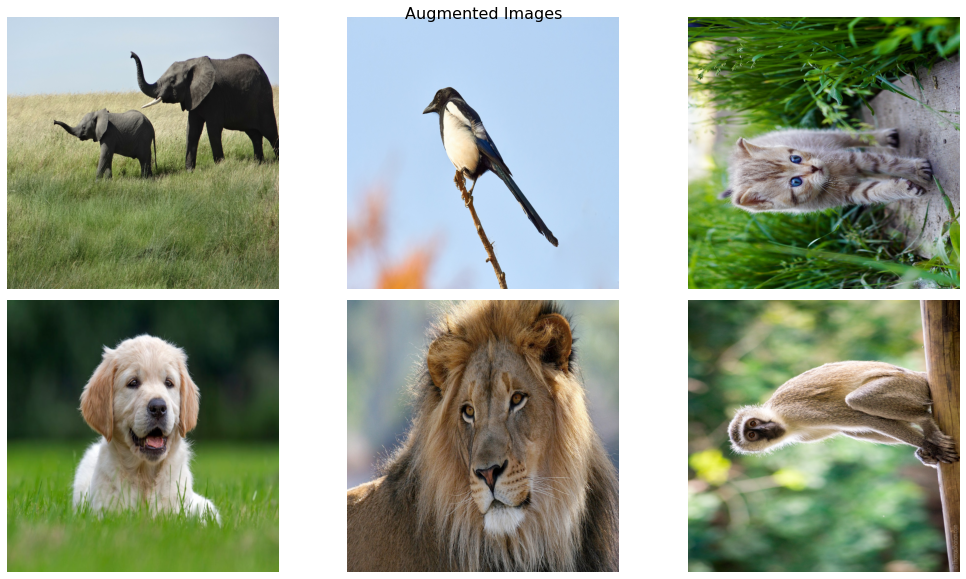

In [179]:

# Download the images
download_images()

# Read and resize
images = read_images()
print("Total number of images: {}".format(images.shape))

# Batch augment images
for i in range(3):
    print("Call: ", i + 1, end=" => ")
    key=random.PRNGKey(0)
    start_time = time.time()
    augmented = augment_images(images, key)
    print(f"Time taken to generate augmentations: {time.time()-start_time:.2f}")

# Plot the augmented images    
plot_images(augmented, len(augmented), title="Augmented Images")


4. Notice the improvement in timing once both vectorization and jit transformations are used.

In [180]:
# Clean up
delete_images()

Deleting images finished


##### Using pmap
1. **`pmap`** is very similar to **`vmap`** in terms fo API. While **`vmap`** does SIMD, **`pmap`** does SMPD, i.e. it takes the python program and replicates it across multiple devices and runs everything in parallel. Note that **`pmap`** compiles the underlying function, so **`jit`** is not needed
2. We will now create a new version of the **`augment_image`** function that runs 8 parallel operations, each batch augmenting 8 images. **Note** that this would require 8 TPUs/GPU threads to run

In [ ]:
# Get the vmapped version of our augmentation functions
random_rotate_vmapped = vmap(random_rotate, in_axes=(0, 0))
random_horizontal_flip_vmapped = vmap(random_horizontal_flip, in_axes=(0, 0))
random_vertical_flip_vmapped = vmap(random_vertical_flip, in_axes=(0, 0))

def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    
    """
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_vmapped(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_vmapped(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_vmapped(augmented, flip)
    
    return augmented

# Generate a big batch of 8 x num images in batch
big_batch_images = jnp.stack([images for i in range(8)])

# Generate a batch of keys as well as the augment_images
# function accepts a key as well
key = random.PRNGKey(123)
big_batch_keys = [key]
for i in range(7):
    key, subkey = random.split(key)
    big_batch_keys.append(key)

big_batch_keys = jnp.stack(big_batch_keys)

print("Number of image batches = {}, number of keys = {}".format(len(big_batch_images), len(big_batch_keys)))

# Pmapped function
pmapped_augment_images = pmap(augment_images, in_axes=(0,0))

# We will run it more than once
for i in range(3):
    print("Call: ", i + 1, end=" => ")
    start_time = time.time()
    augmented_parallel = pmapped_augment_images(big_batch_images, big_batch_keys)
    print(f"Time taken to generate augmentations: {time.time()-start_time:.2f}")
    

# Plot the augmenetd images
augmented_parallel = augmented_parallel.reshape(64, 800, 800, 3)
plot_images(augmented_parallel,
            batch_size=64,
            title="Augmentation on parallel devices",
            figsize=(20, 25)
           )